In [585]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

#

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

#

import xgboost as xgb
import lightgbm as lgt

#

import warnings
warnings.filterwarnings('ignore')
import string

In [586]:
def append_df (train_data, test_data):
    return train_data.append(test_data, sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [587]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df = append_df(train_df, test_df)

In [588]:
print(f'Training Shape: {train_df.shape}')
print('-'*50)
print(f'Test Shape: {test_df.shape}')

Training Shape: (891, 12)
--------------------------------------------------
Test Shape: (418, 11)


In [589]:
train_df_cols = train_df.columns.tolist()
test_df_cols = test_df.columns.tolist()
print(train_df_cols)
print('-'*80)
print(test_df_cols)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
--------------------------------------------------------------------------------
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


# EXP D. Analysis

In [590]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

In [591]:
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

In [592]:
train_df.name = 'Training Set'
test_df.name = 'Test Set'
full_df.name = 'Full Set' 
dfs = [train_df, test_df]
def missing_d(df):
    for col in df.columns.tolist():
        print(f'{col} column missing {df[col].isna().sum()} values.')
    print('\n')
        
for df in dfs:
    print(f'{df.name}')
    missing_d(df)

Training Set
PassengerId column missing 0 values.
Survived column missing 0 values.
Pclass column missing 0 values.
Name column missing 0 values.
Sex column missing 0 values.
Age column missing 177 values.
SibSp column missing 0 values.
Parch column missing 0 values.
Ticket column missing 0 values.
Fare column missing 0 values.
Cabin column missing 687 values.
Embarked column missing 2 values.


Test Set
PassengerId column missing 0 values.
Pclass column missing 0 values.
Name column missing 0 values.
Sex column missing 0 values.
Age column missing 86 values.
SibSp column missing 0 values.
Parch column missing 0 values.
Ticket column missing 0 values.
Fare column missing 1 values.
Cabin column missing 327 values.
Embarked column missing 0 values.




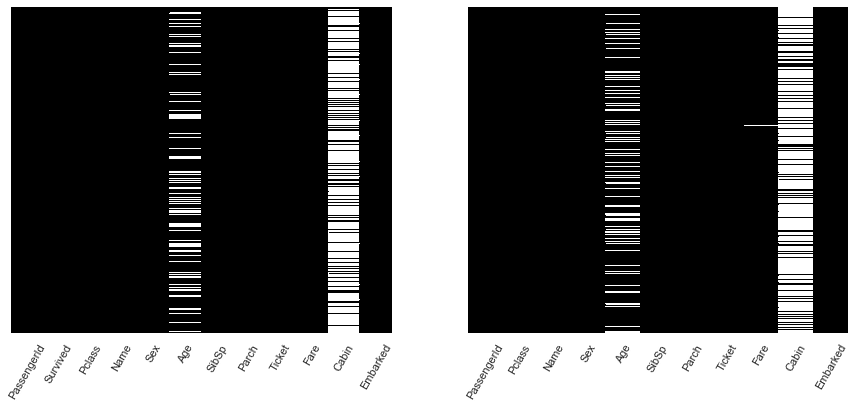

In [593]:
sns.set()
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
sns.heatmap(train_df.isna(), yticklabels=False, cbar=False, cmap='cubehelix', ax=ax[0])
sns.heatmap(test_df.isna(), yticklabels=False, cbar=False, cmap='cubehelix', ax=ax[1])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.show()

In [594]:
full_df_corr = full_df.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
full_df_corr.rename(columns={"level_0": "Feature 1", 
                             "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
full_df_corr[full_df_corr['Feature 1'] == 'Age'].style.background_gradient(cmap='summer_r')

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [595]:
age_by_pclass_sex = full_df.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print(f'Median age of Pclass {pclass}, {sex}s:, {age_by_pclass_sex[sex][pclass]}')
print(f'Median age of all passengers: {full_df.Age.median()}')

full_df['Age'] = full_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1, females:, 36.0
Median age of Pclass 1, males:, 42.0
Median age of Pclass 2, females:, 28.0
Median age of Pclass 2, males:, 29.5
Median age of Pclass 3, females:, 22.0
Median age of Pclass 3, males:, 25.0
Median age of all passengers: 28.0


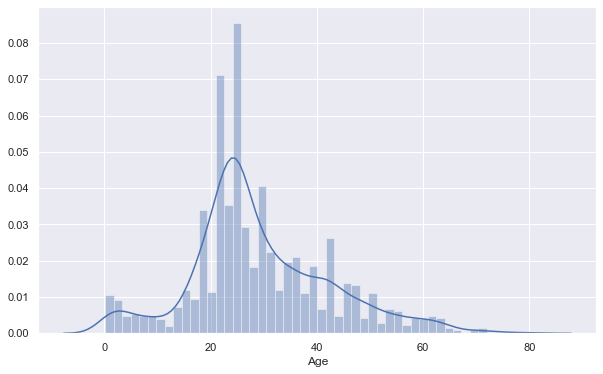

In [596]:
plt.subplots(figsize=(10, 6))
sns.distplot(full_df['Age'],bins=50)
plt.show()

In [597]:
full_df[full_df['Embarked'].isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [598]:
full_df['Embarked'] = full_df['Embarked'].fillna('S')

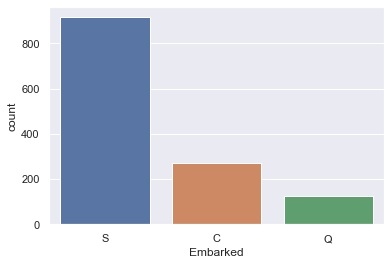

In [599]:
sns.countplot(full_df['Embarked'])

In [600]:
full_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [601]:
full_df[full_df['Fare'].isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [602]:
full_df['Fare'] = full_df.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].apply(lambda x: x.fillna(x.median()))

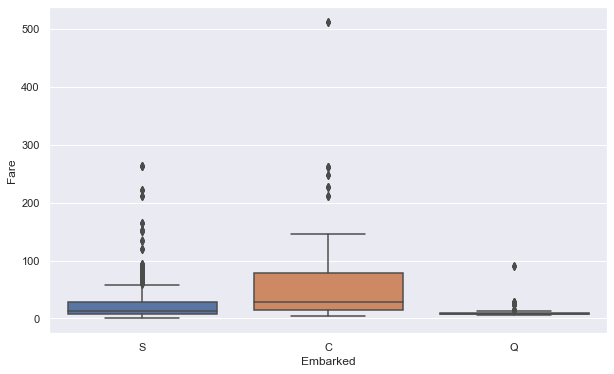

In [603]:
plt.subplots(figsize=(10, 6))
sns.boxplot(x=full_df['Embarked'],y= full_df['Fare'])
plt.show()

In [604]:
full_df['Cabin'].value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F2                 4
D                  4
                  ..
T                  1
A14                1
B50                1
C110               1
C111               1
Name: Cabin, Length: 186, dtype: int64

In [605]:
full_df['Deck'] = full_df['Cabin'].apply(lambda c: c[0] if pd.notnull(c) else 'M')
full_df['Deck'].value_counts()

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64

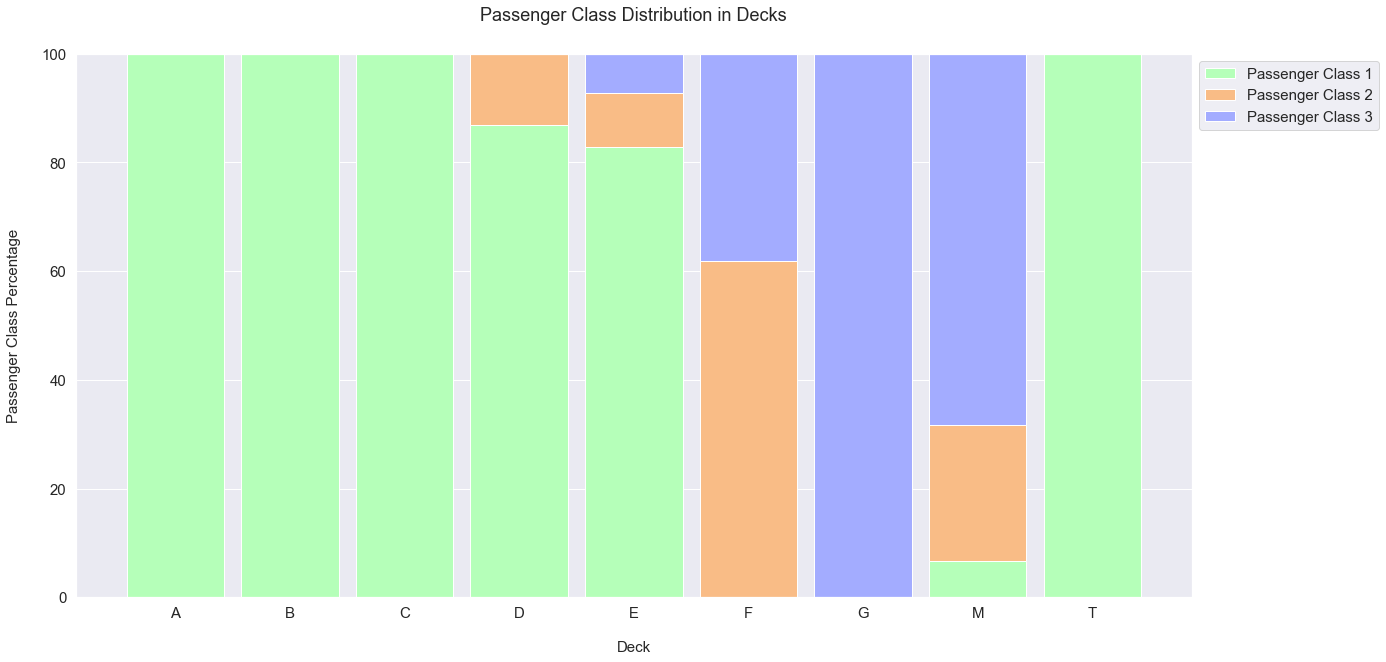

In [606]:
full_df['Deck'] = full_df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = full_df.groupby(['Deck', 'Pclass']).count().drop(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket'], axis=1).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [607]:
idx = full_df[full_df['Deck'] == 'T'].index
full_df.loc[idx, 'Deck'] = 'A'

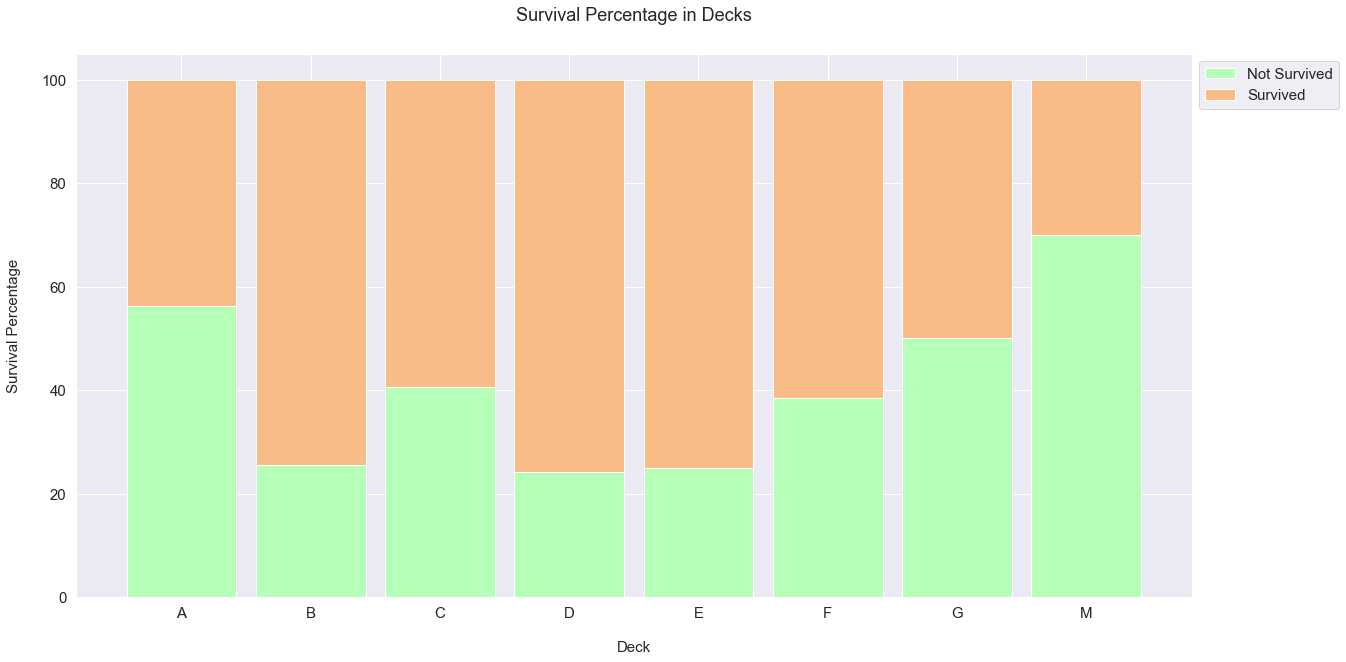

In [608]:
df_all_decks_survived = full_df.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [609]:
full_df['Deck'] = full_df['Deck'].replace(['A', 'B', 'C'], 'ABC')
full_df['Deck'] = full_df['Deck'].replace(['D', 'E'], 'DE')
full_df['Deck'] = full_df['Deck'].replace(['F', 'G'], 'FG')

full_df['Deck'].value_counts(normalize=True)

M      0.774637
ABC    0.139037
DE     0.066463
FG     0.019862
Name: Deck, dtype: float64

In [610]:
full_df.drop(['Cabin'], axis=1, inplace=True)

In [611]:
train_df, test_df = divide_df(full_df)
dfs = [train_df, test_df]

for df in dfs:
    missing_d(df)

Age column missing 0 values.
Embarked column missing 0 values.
Fare column missing 0 values.
Name column missing 0 values.
Parch column missing 0 values.
PassengerId column missing 0 values.
Pclass column missing 0 values.
Sex column missing 0 values.
SibSp column missing 0 values.
Survived column missing 0 values.
Ticket column missing 0 values.
Deck column missing 0 values.


Age column missing 0 values.
Embarked column missing 0 values.
Fare column missing 0 values.
Name column missing 0 values.
Parch column missing 0 values.
PassengerId column missing 0 values.
Pclass column missing 0 values.
Sex column missing 0 values.
SibSp column missing 0 values.
Ticket column missing 0 values.
Deck column missing 0 values.




In [612]:
full_df['Survived'].value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

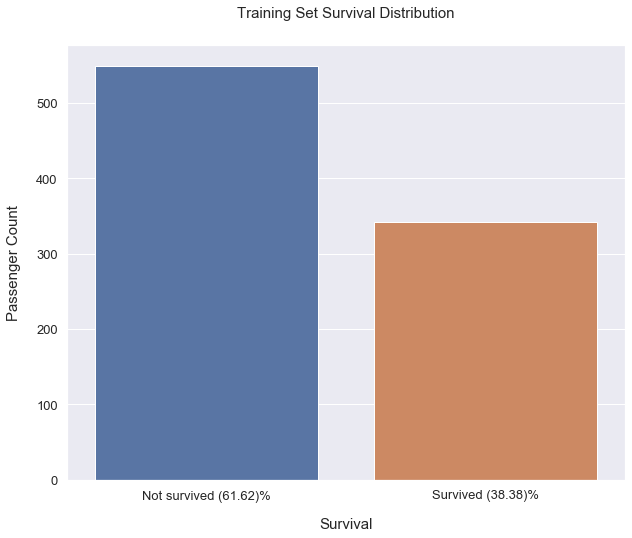

In [613]:
survived = train_df['Survived'].value_counts()[1]
not_survived = train_df['Survived'].value_counts()[0]
survived_per = survived / train_df.shape[0] * 100
not_survived_per = not_survived / train_df.shape[0] * 100

plt.figure(figsize=(10, 8))
sns.countplot(train_df['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0,1), [f'Not survived ({not_survived_per:.2f})%',f'Survived ({survived_per:.2f})%'])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

In [614]:
train_df_corr =train_df.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
train_df_corr.rename(columns={"level_0": "Feature 1", 
                             "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
train_df_corr.drop(train_df_corr.iloc[1::2].index, inplace=True)
train_df_corr_nd = train_df_corr.drop(train_df_corr[train_df_corr['Correlation Coefficient'] == 1.0].index)


test_df_corr =test_df.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
test_df_corr.rename(columns={"level_0": "Feature 1", 
                             "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
test_df_corr.drop(test_df_corr.iloc[1::2].index, inplace=True)
test_df_corr_nd = test_df_corr.drop(test_df_corr[test_df_corr['Correlation Coefficient'] == 1.0].index)

In [615]:
corr_mask = train_df_corr_nd['Correlation Coefficient'] > 0.1
train_df_corr_nd[corr_mask].style.background_gradient(cmap='summer_r')

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [616]:
corr_mask = test_df_corr_nd['Correlation Coefficient'] > 0.1
test_df_corr_nd[corr_mask].style.background_gradient(cmap='summer_r')

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Fare,Age,0.345347
12,Parch,SibSp,0.306895
14,Fare,Parch,0.230410
16,Fare,SibSp,0.172032


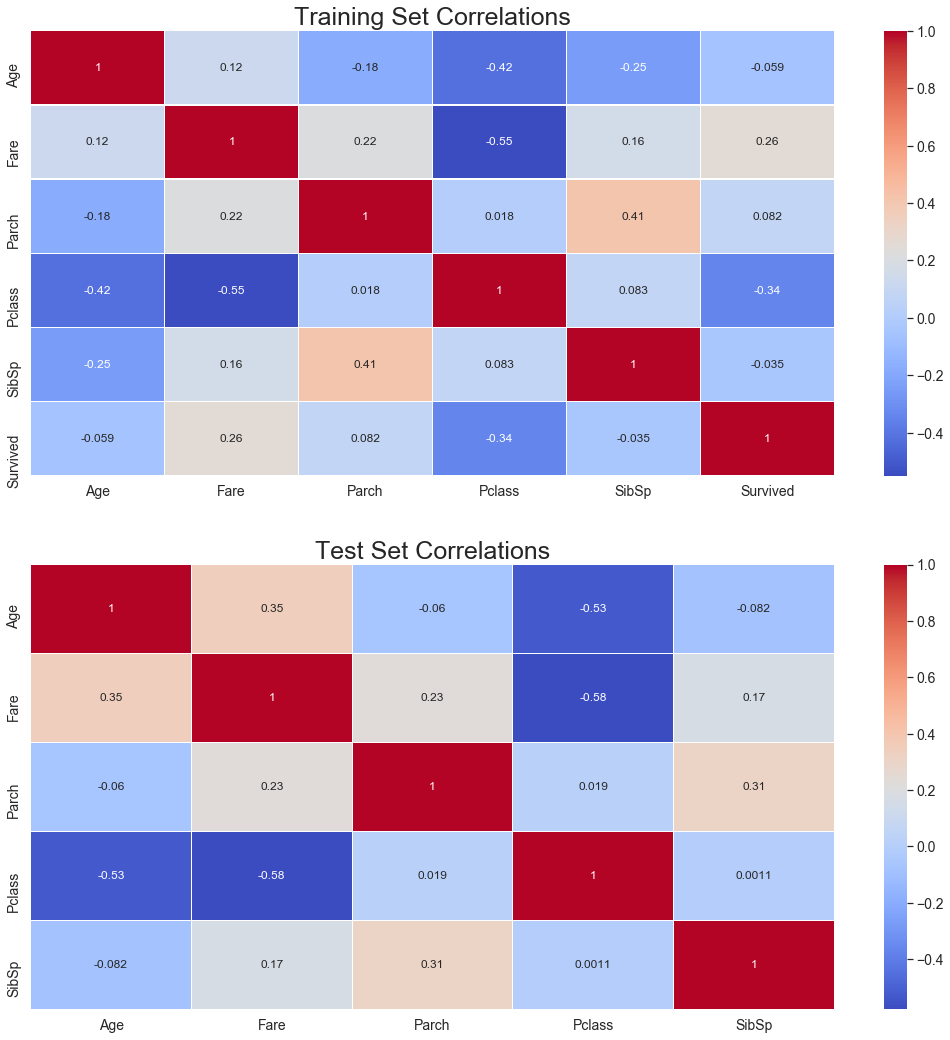

In [617]:
fig, ax = plt.subplots(nrows=2, figsize=(18,18))

sns.heatmap(train_df.drop(['PassengerId'], axis=1).corr(), ax=ax[0],annot=True, cmap='coolwarm', linewidths=0.2)
sns.heatmap(test_df.drop(['PassengerId'], axis=1).corr(), ax=ax[1],annot=True, cmap='coolwarm', linewidths=0.2)

ax[0].set_title('Training Set Correlations', size=25)
ax[1].set_title('Test Set Correlations', size=25)

for ax in fig.axes:
    plt.sca(ax)
    ax.tick_params(axis='x', labelsize= 14)
    ax.tick_params(axis='y', labelsize= 14)



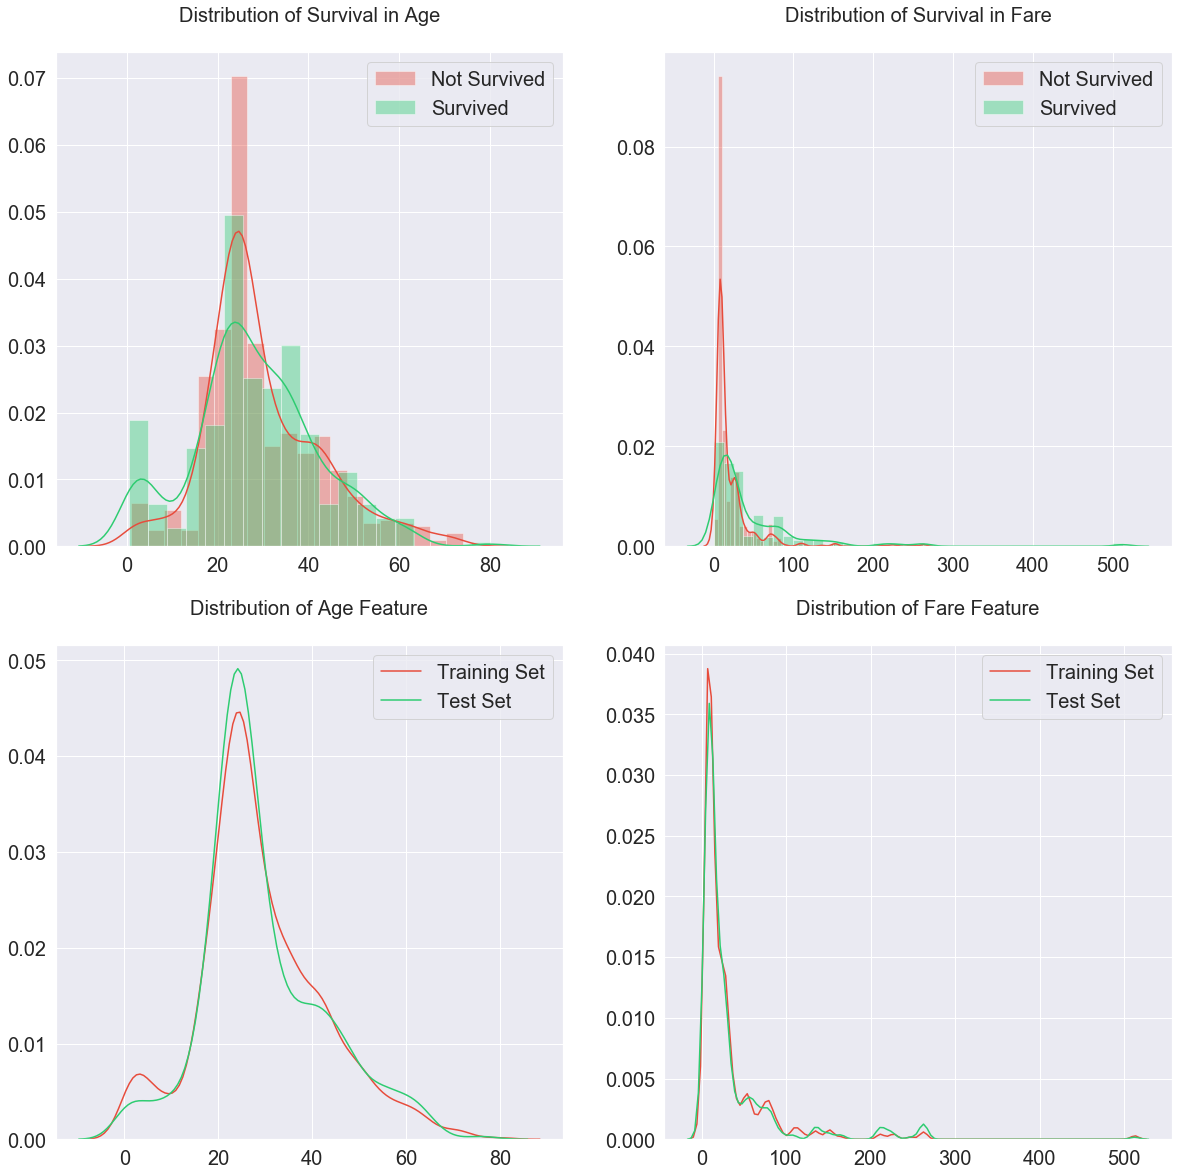

In [618]:
cont_features = ['Age', 'Fare']
surv = train_df['Survived'] == 1

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,20))

for i, feature in enumerate(cont_features):
    sns.distplot(train_df[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=ax[0][i])
    sns.distplot(train_df[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=ax[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train_df[feature], label='Training Set', hist=False, color='#e74c3c', ax=ax[1][i])
    sns.distplot(test_df[feature], label='Test Set', hist=False, color='#2ecc71', ax=ax[1][i])
    
    ax[0][i].set_xlabel('')
    ax[1][i].set_xlabel('')
    
    for j in range(2):        
        ax[i][j].tick_params(axis='x', labelsize=20)
        ax[i][j].tick_params(axis='y', labelsize=20)
    
    ax[0][i].legend(loc='upper right', prop={'size': 20})
    ax[1][i].legend(loc='upper right', prop={'size': 20})
    ax[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

ax[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
ax[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()
    

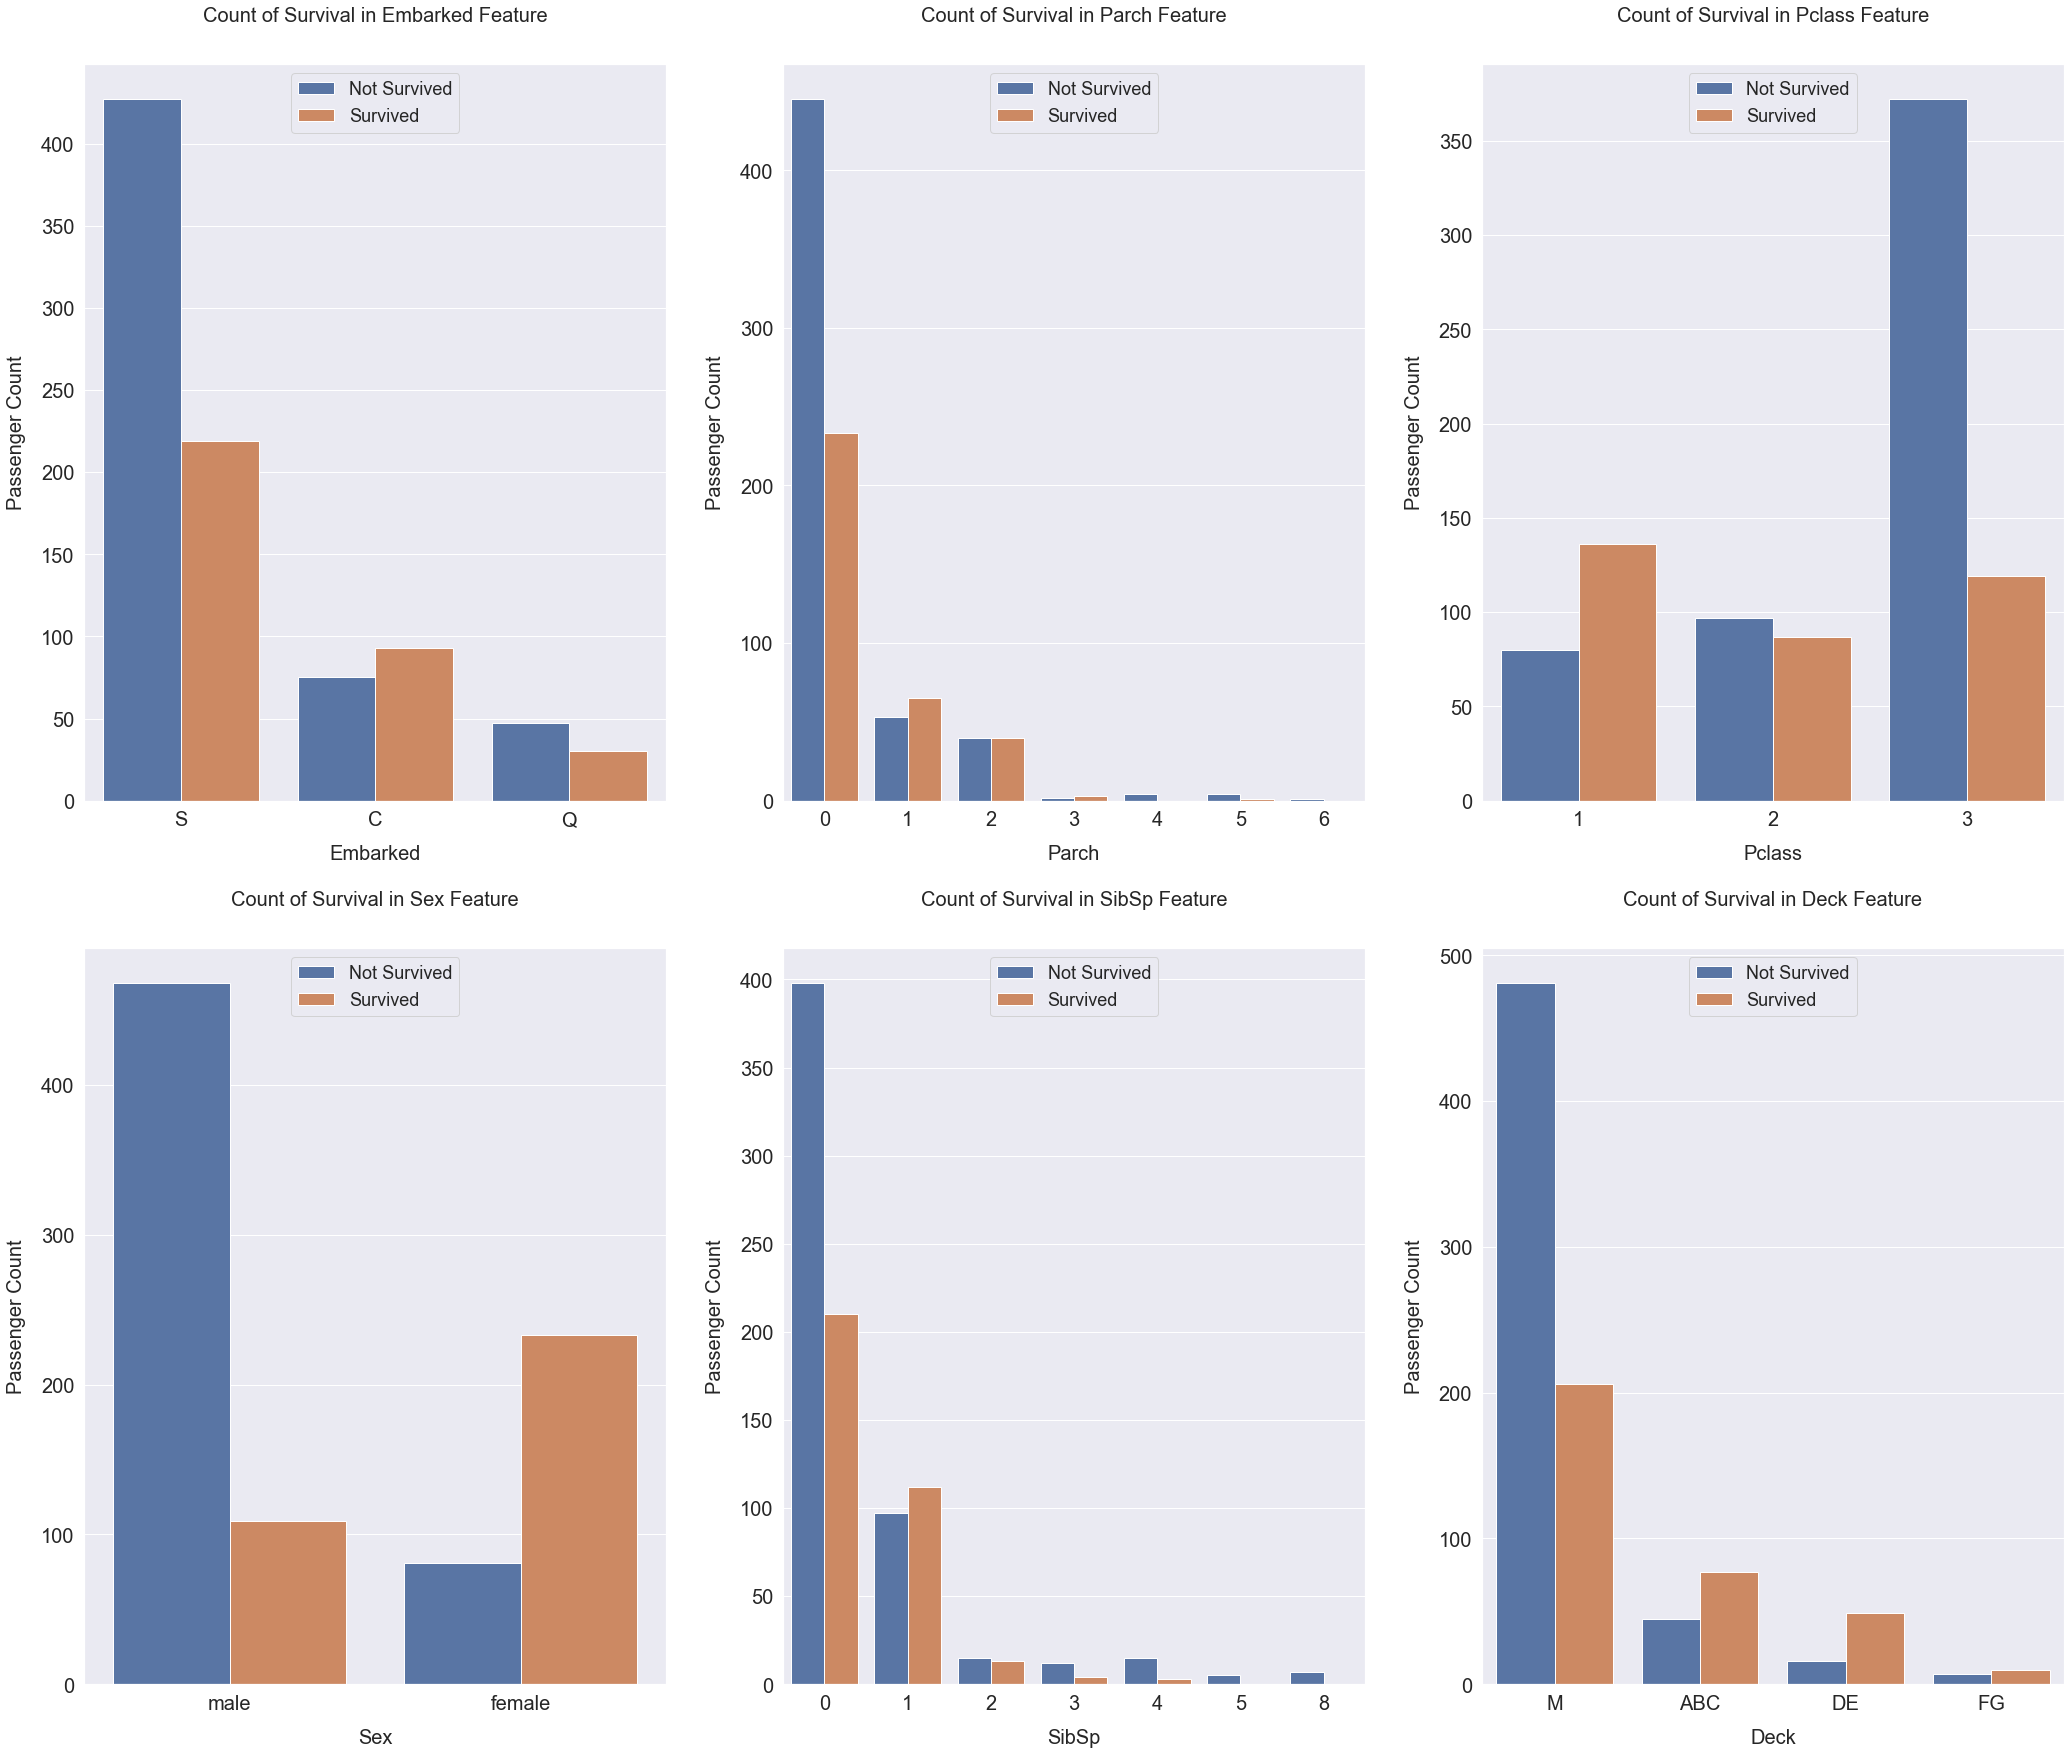

In [619]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train_df)
    
    plt.xlabel(f'{feature}', size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title(f'Count of Survival in {feature} Feature', size=20, y=1.05)

plt.show()

In [620]:
full_df = append_df(train_df, test_df)
display(full_df.head())

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [621]:
full_df['Fare'] = pd.qcut(full_df['Fare'], 13)

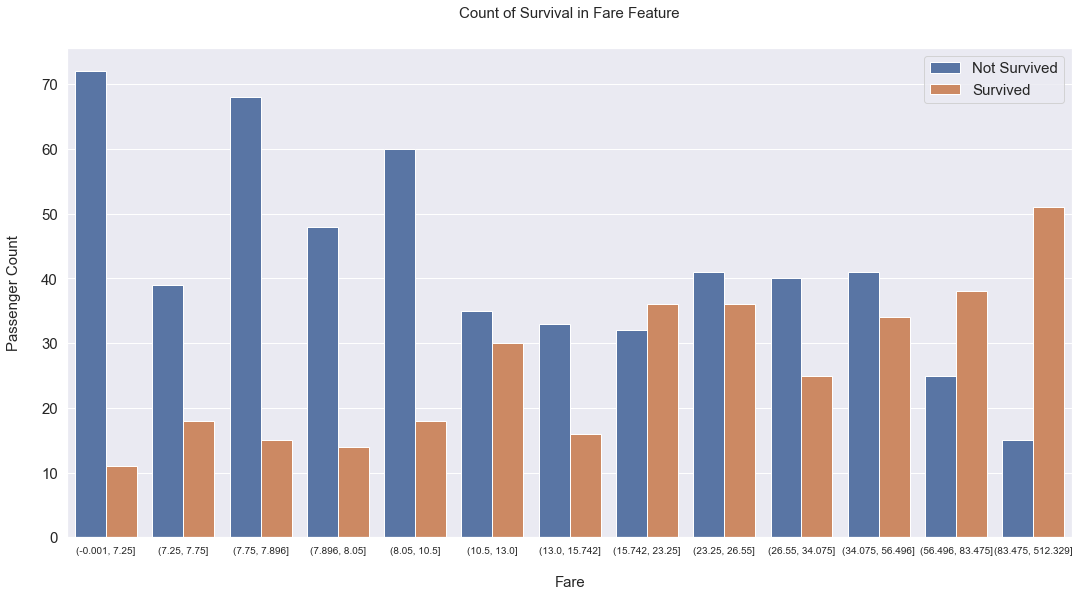

In [622]:
fig, ax = plt.subplots(figsize=(18,9))
sns.countplot(x='Fare', hue='Survived', data= full_df)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title(f'Count of Survival in Fare Feature', size=15, y=1.05)

plt.show()

In [623]:
full_df['Age'] = pd.qcut(full_df['Age'], 12)

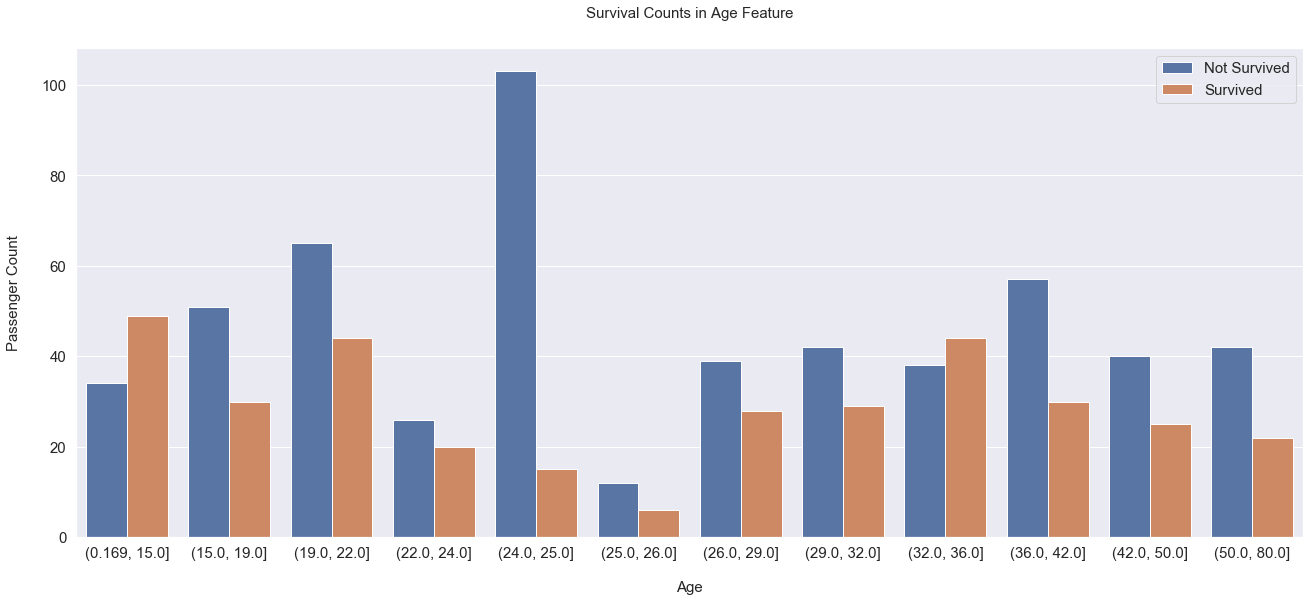

In [624]:
fig, ax = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=full_df)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in Age Feature', size=15, y=1.05)

plt.show()

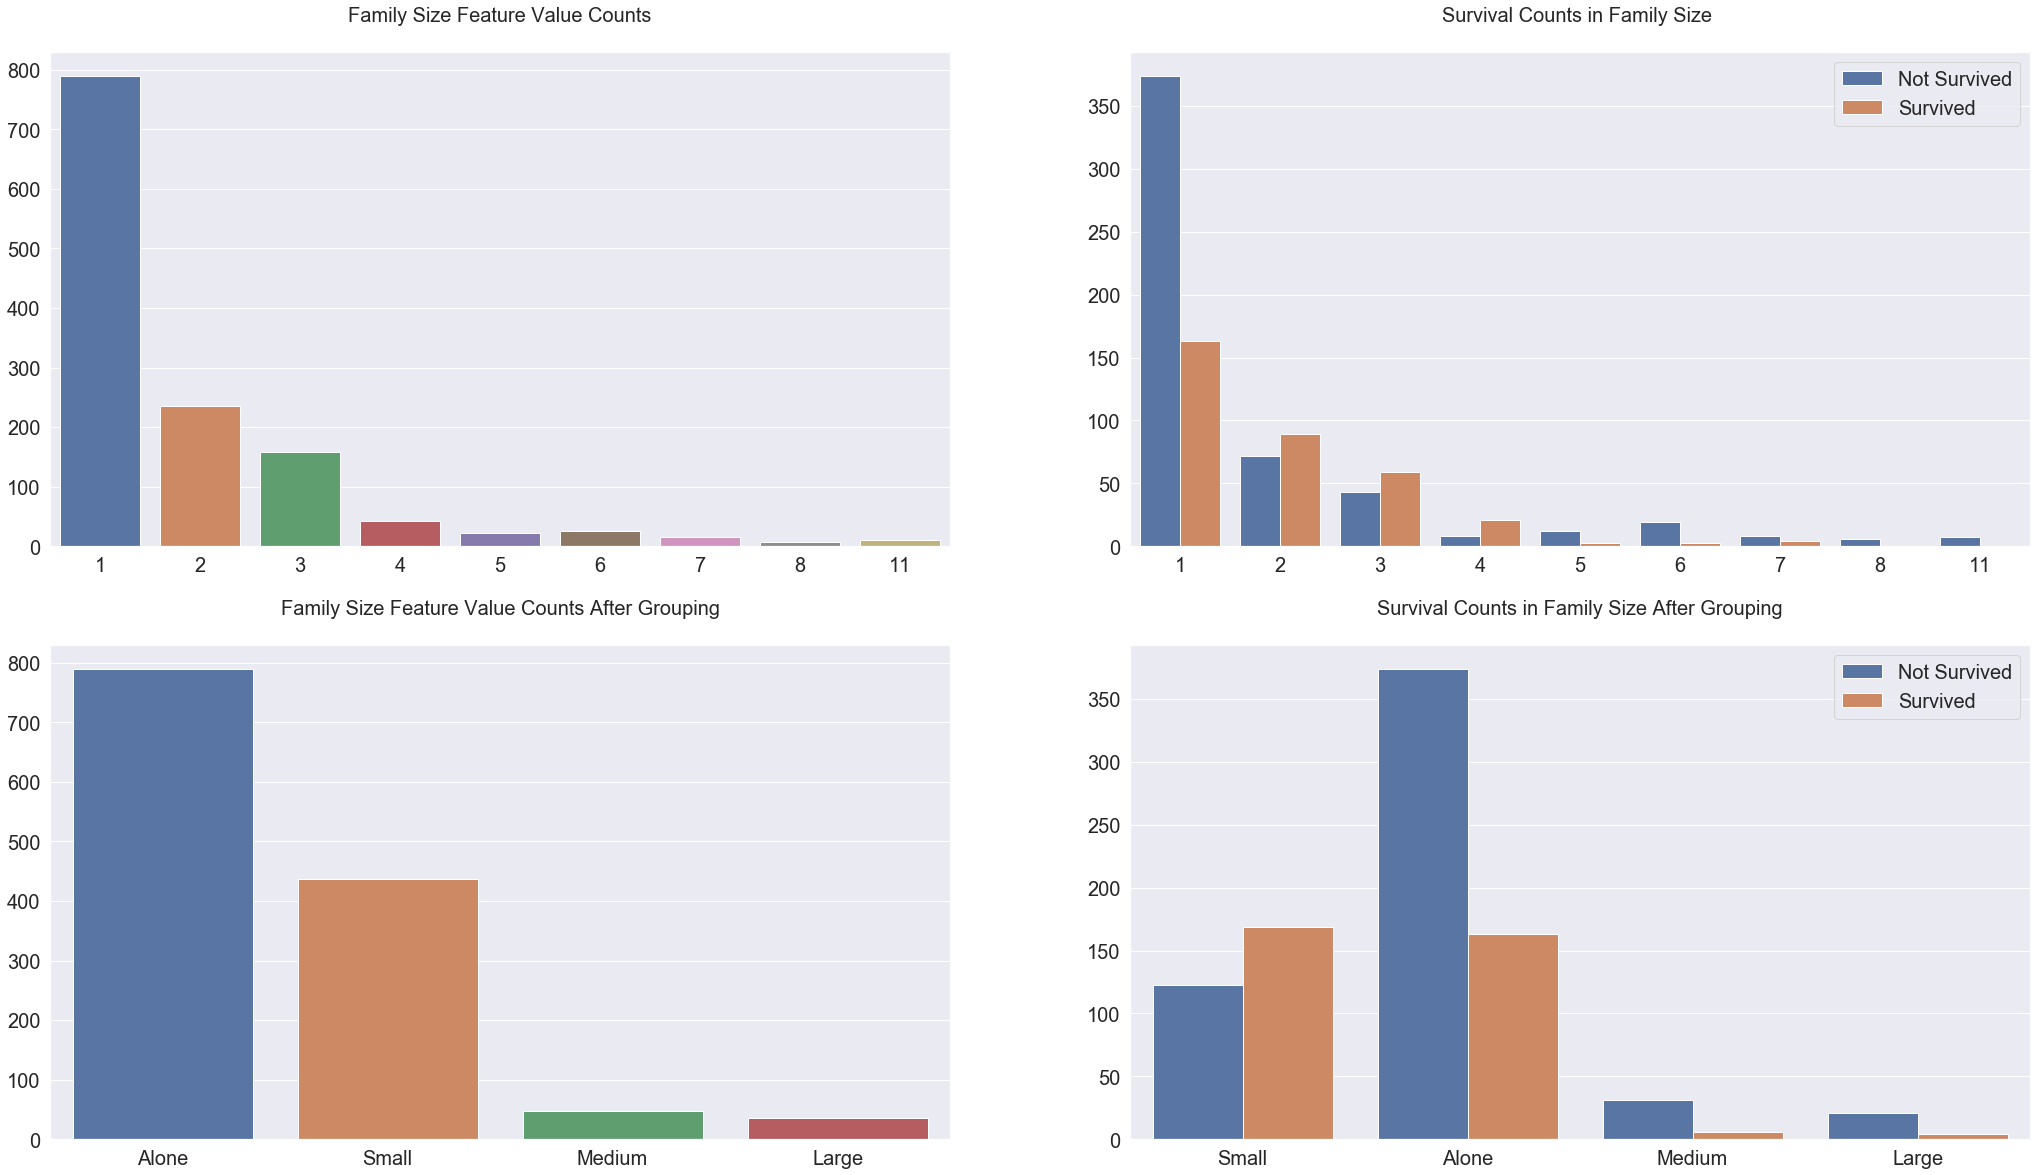

In [625]:
full_df['Family_Size'] = full_df['SibSp'] + full_df['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=full_df['Family_Size'].value_counts().index, y=full_df['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=full_df, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
full_df['Family_Size_Grouped'] = full_df['Family_Size'].map(family_map)

sns.barplot(x=full_df['Family_Size_Grouped'].value_counts().index, y=full_df['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=full_df, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

In [626]:
full_df['Ticket_Frequency'] = full_df.groupby('Ticket')['Ticket'].transform('count')

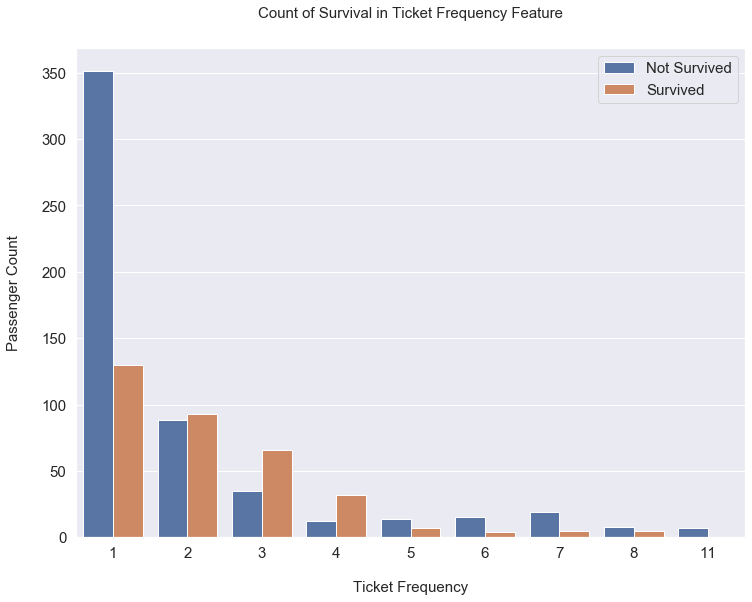

In [627]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=full_df)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

In [628]:
full_df['Title'] = full_df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
full_df['Is_Married'] = 0
full_df['Is_Married'].loc[full_df['Title'] == 'Mrs'] = 1

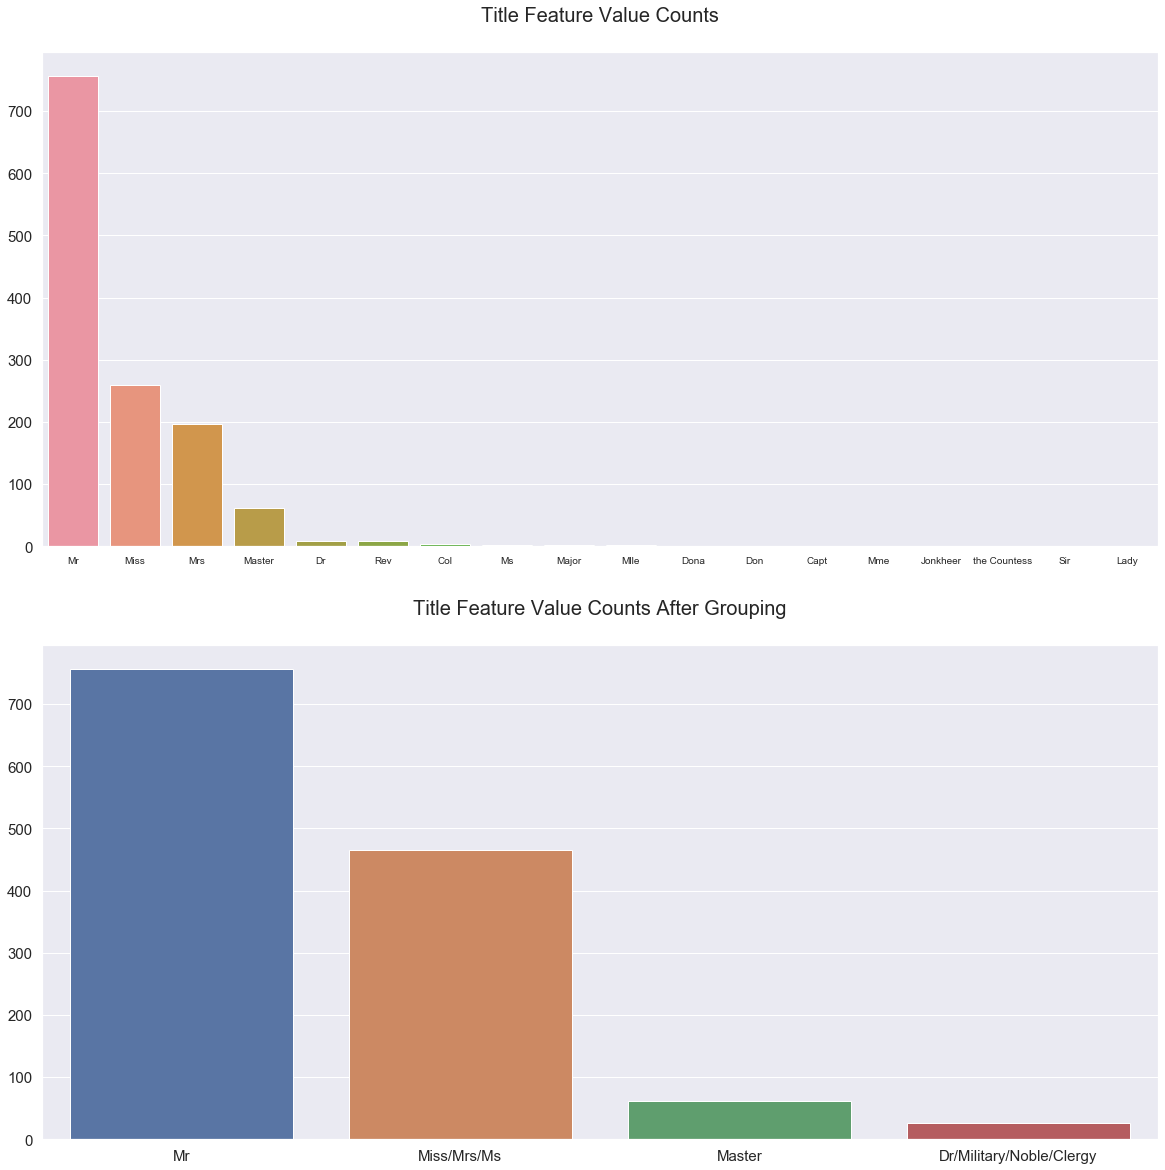

In [629]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=full_df['Title'].value_counts().index, y=full_df['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

full_df['Title'] = full_df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
full_df['Title'] = full_df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=full_df['Title'].value_counts().index, y=full_df['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

In [630]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

full_df['Family'] = extract_surname(full_df['Name'])
train_df = full_df.loc[:890]
test_df = full_df.loc[891:]
dfs = [train_df, test_df]

In [631]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in train_df['Family'].unique() if x in test_df['Family'].unique()]
non_unique_tickets = [x for x in train_df['Ticket'].unique() if x in test_df['Ticket'].unique()]

df_family_survival_rate = train_df.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = train_df.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [632]:
mean_survival_rate = np.mean(train_df['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(train_df)):
    if train_df['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[train_df['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(test_df)):
    if test_df['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[test_df['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
train_df['Family_Survival_Rate'] = train_family_survival_rate
train_df['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
test_df['Family_Survival_Rate'] = test_family_survival_rate
test_df['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(train_df)):
    if train_df['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[train_df['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(test_df)):
    if test_df['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[test_df['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
train_df['Ticket_Survival_Rate'] = train_ticket_survival_rate
train_df['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
test_df['Ticket_Survival_Rate'] = test_ticket_survival_rate
test_df['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [633]:
for df in [train_df, test_df]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [634]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [635]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

In [636]:
for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

train_df = pd.concat([train_df, *encoded_features[:6]], axis=1)
test_df = pd.concat([test_df, *encoded_features[6:]], axis=1)

In [637]:
full_df = append_df(train_df, test_df)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

full_df.drop(columns=drop_cols, inplace=True)

full_df.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,8,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


# Modelling

In [638]:
X_train = StandardScaler().fit_transform(train_df.drop(columns=drop_cols))
y_train = train_df['Survived'].values
X_test = StandardScaler().fit_transform(test_df.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [639]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1) 

In [640]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=full_df.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 1 OOB Score: 0.8595505617977528

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 2 OOB Score: 0.8457223001402524

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 3 OOB Score: 0.8513323983169705

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 4 OOB Score: 0.8373071528751753

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 5 OOB Score: 0.8302945301542777

Average OOB Score: 0.8448413886568857


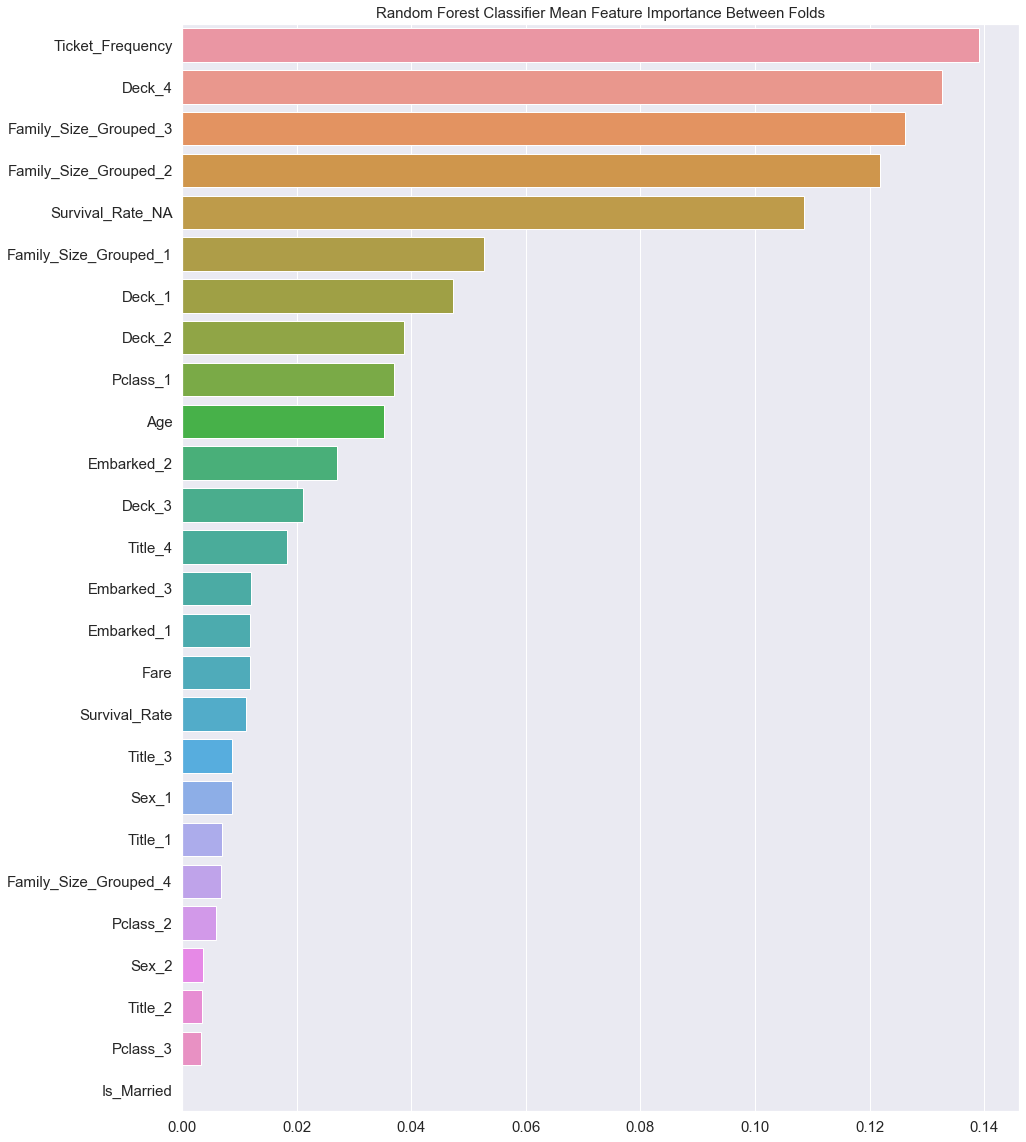

In [641]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

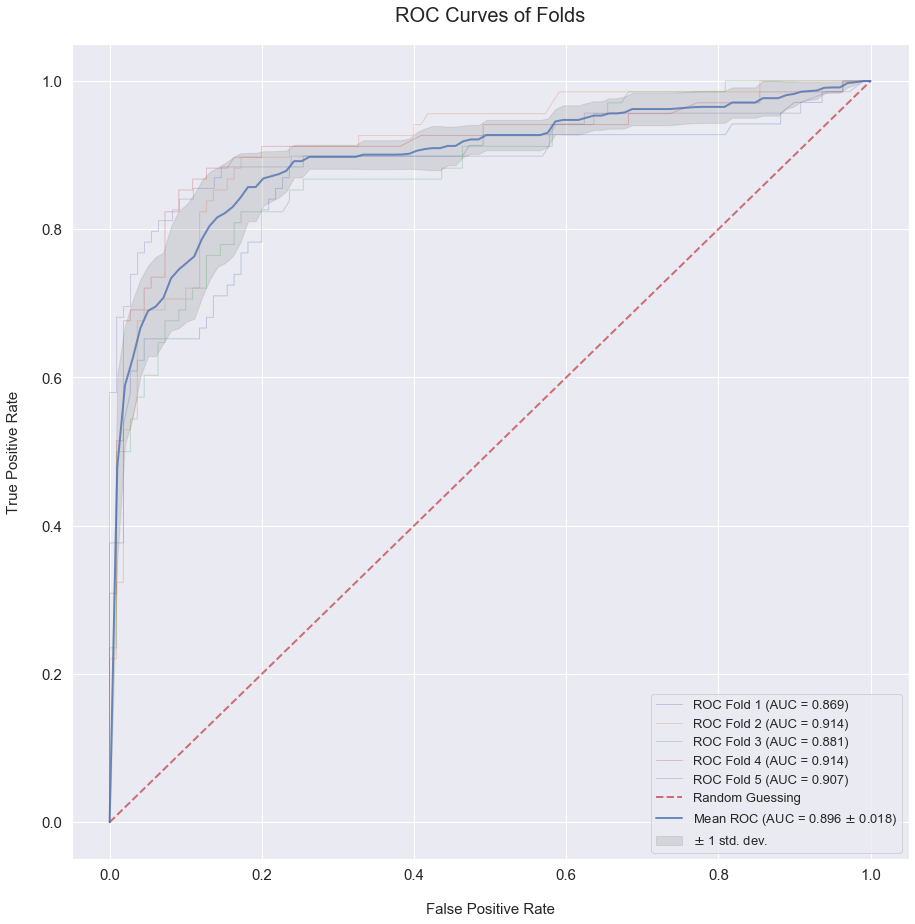

In [642]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

In [643]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test_df['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
